In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2023-11-10 08:38:16--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-11-10 08:38:17--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-11-10 08:38:17--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-str

In [ ]:
import os
input_dir = "images/"
target_dir = "annotations/trimaps/"
input_img_paths = sorted(
  [os.path.join(input_dir,fname)
  for fname in os.listdir(input_dir)
  if fname.endswith(".jpg")])

In [ ]:
target_paths = sorted(
  [os.path.join(target_dir, fname)
  for fname in os.listdir(target_dir)
  if fname.endswith(".png") and not fname.startswith(".")])

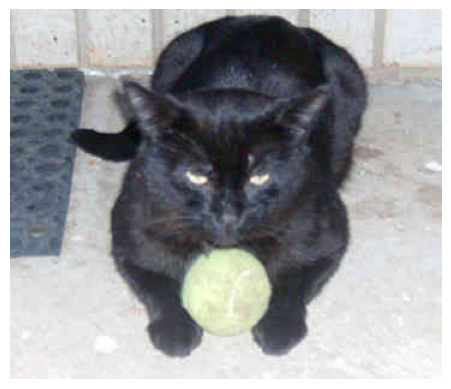

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
plt.axis("off" )
plt.imshow(load_img(input_img_paths[666]))

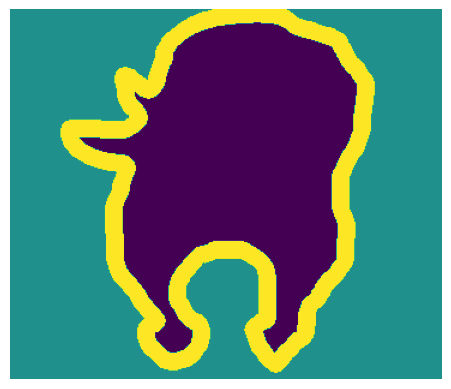

In [ ]:
def display_target(target_array):
 normalized_array = (target_array.astype("uint8") - 1) *127
 plt.axis("off")
 plt.imshow(normalized_array[:,:,0])
img = img_to_array(load_img(target_paths[666], color_mode="grayscale"))
display_target(img)

In [ ]:
import numpy as np
import random
img_size = (200,200)
num_imgs = len(input_img_paths)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
  return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
  img = img_to_array(
  load_img(path, target_size=img_size, color_mode="grayscale"))
  img = img.astype("uint8") - 1
  return img

In [ ]:
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
 input_imgs[i] =path_to_input_image(input_img_paths[i])
 targets[i] = path_to_target(target_paths[i])
 num_val_samples = 1000
 train_input_imgs = input_imgs[: -num_val_samples ]
 train_targets = targets[: -num_val_samples]
 val_input_imgs = input_imgs[-num_val_samples: ]
 val_targets = targets[-num_val_samples : ]

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(ing_size, num_classes):
 inputs = keras.Input(shape=img_size +(3,))
 x = layers.Rescaling(1./255)(inputs)
 x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
 x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
 x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same") (x)
 x = layers.Conv2D(128, 3, activation="relu", padding="same") (x)
 x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
 x = layers.Conv2D(256, 3, activation="relu", padding="same") (x)
 x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same") (x)
 x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
 x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same" ) (x)
 x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
 x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
 x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
 outputs = layers.Conv2D(num_classes, 3, activation="softmax",padding="same") (x)
 CNNmodel = keras.Model(inputs, outputs)
 return CNNmodel

In [ ]:
CNNmodel = get_model(img_size, num_classes=3)
CNNmodel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 100, 100, 64)      1792      
                                                                 
 conv2d_26 (Conv2D)          (None, 100, 100, 64)      36928     
                                                                 
 conv2d_27 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 conv2d_28 (Conv2D)          (None, 50, 50, 128)       147584    
                                                                 
 conv2d_29 (Conv2D)          (None, 25, 25, 256)       2951

In [ ]:
CNNmodel.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks =[keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",save_best_only=True)]

history = CNNmodel.fit(train_input_imgs, train_targets,
                       epochs=1,
                       callbacks=callbacks,
                       batch_size=64,
                       validation_data=(val_input_imgs, val_targets))

 19/100 [====>.........................] - ETA: 55:08 - loss: 0.9904

KeyboardInterrupt: ignored

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]

In [ ]:
val_loss = history.history["val_loss" ]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt. legend()

In [ ]:
from tensorflow.keras.utils import array_to_img
model = keras.models.load_model("oxford_segmentation.keras")

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np._expand_dims(test_image, 0)) [0]

def display_mask(pred):
 mask = np.argmax(pred, axis=-1)
 mask *= 127
 plt.axis("off")
 plt.imshow(mask)

display_mask(mask)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255) (inputs)
def residual_block(x, filters, pooling=False):
 residual = x
 x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
 x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
 if pooling:
  x = layers.MaxPooling2D(2, padding="same") (x)
  residual = layers.Conv2D(filters, 1, strides=2)(residual)
 elif filters != residual.shape[-1]:
   residual = layers.Conv2D(filters,1)(residual)
   x = layers.add([x,residual])
 return x

x = residual_block(x,filters=32, pooling=True)
x = residual_block(x,filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
residualmodel = keras.Model(inputs=inputs, outputs=outputs)
residualmodel.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, 32, 32, 3)            0         ['input_7[0][0]']             
                                                                                                  
 conv2d_50 (Conv2D)          (None, 32, 32, 32)           896       ['rescaling_6[0][0]']         
                                                                                                  
 conv2d_51 (Conv2D)          (None, 32, 32, 32)           9248      ['conv2d_50[0][0]']           
                                                                                            

In [ ]:
inputs = keras. Input(shape=(180, 180,3))
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),layers.RandomRotation(0.1),layers.RandomZoom(0.2),])
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
 residual = x
 x = layers.BatchNormalization()(x)
 x = layers.Activation("relu") (x)
 x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
 x = layers.BatchNormalization()(x)
 x = layers.Activation("relu")(x)
 x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
 x = layers.MaxPooling2D(3, strides=2, padding="same") (x)
 residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
 x = layers.add([x, residual])

In [ ]:
x = layers.GlobalAveragePooling2D()(x)

#We apply a series of convolutional blocks with increasing feature depth. Each block consists of two
#batch-normalized depthwise separable convolution layers and a max pooling layer, with a residual connection around the entire block.

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

modelnormalization = keras.Model(inputs=inputs, outputs=outputs)
modelnormalization.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 180, 180, 3)          0         ['input_8[0][0]']             
                                                                                                  
 rescaling_7 (Rescaling)     (None, 180, 180, 3)          0         ['sequential[0][0]']          
                                                                                                  
 conv2d_59 (Conv2D)          (None, 176, 176, 32)         2400      ['rescaling_7[0][0]']         
                                                                                            

In [ ]:
#Preprocessing a single image
from tensorflow import keras
import numpy as np

img_path = keras.utils.get_file(fname="cat.jpg",origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
 img = keras.utils.load_img(img_path, target_size=target_size)
 array = keras.utils.img_to_array(img)
 array = np.expand_dims(array, axis=0)
 return array

img_tensor = get_img_array(img_path, target_size=(180,180))

80329/80329 [==============================] - 0s 1us/step


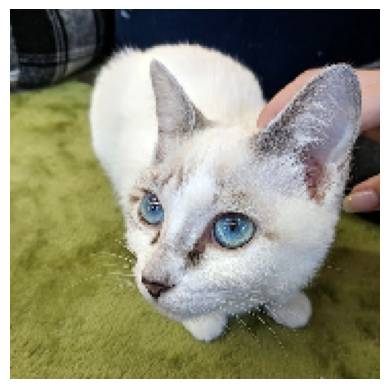

In [ ]:
#Displaying the test picture
import matplotlib.pyplot as plt

plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In [ ]:
#Instantiating a model that returns layer activations
from tensorflow.keras import layers
layer_outputs = []
layer_names = []
for layer in modelnormalization.layers:
 if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
   layer_outputs.append(layer.output)
   layer_names.append(layer.name)

activation_model = keras.Model(inputs=modelnormalization.input,outputs=layer_outputs)
#Using the model to compute layer activations
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 450ms/step


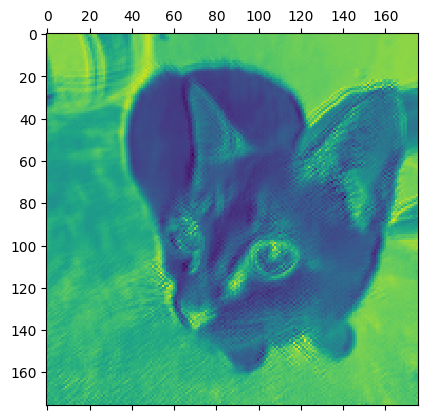

In [ ]:
# Visualizing the fifth channel
import matplotlib.pyplot as plt
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0,:,:,5], cmap="viridis")

In [ ]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros(((size +1)* n_cols-1,images_per_row*(size+1)-1))

  for col in range(n_cols):
    for row in range(images_per_row):
      channel_index = col * images_per_row + row
      channel_image = layer_activation[0,:,:, channel_index].copy()

      if channel_image.sum() != 0:
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
      channel_image = np.clip(channel_image, 0,255).astype("uint8")
      display_grid[
          col * (size + 1): (col + 1) * size + col,
          row * (size + 1) : (row + 1) * size + row] = channel_image

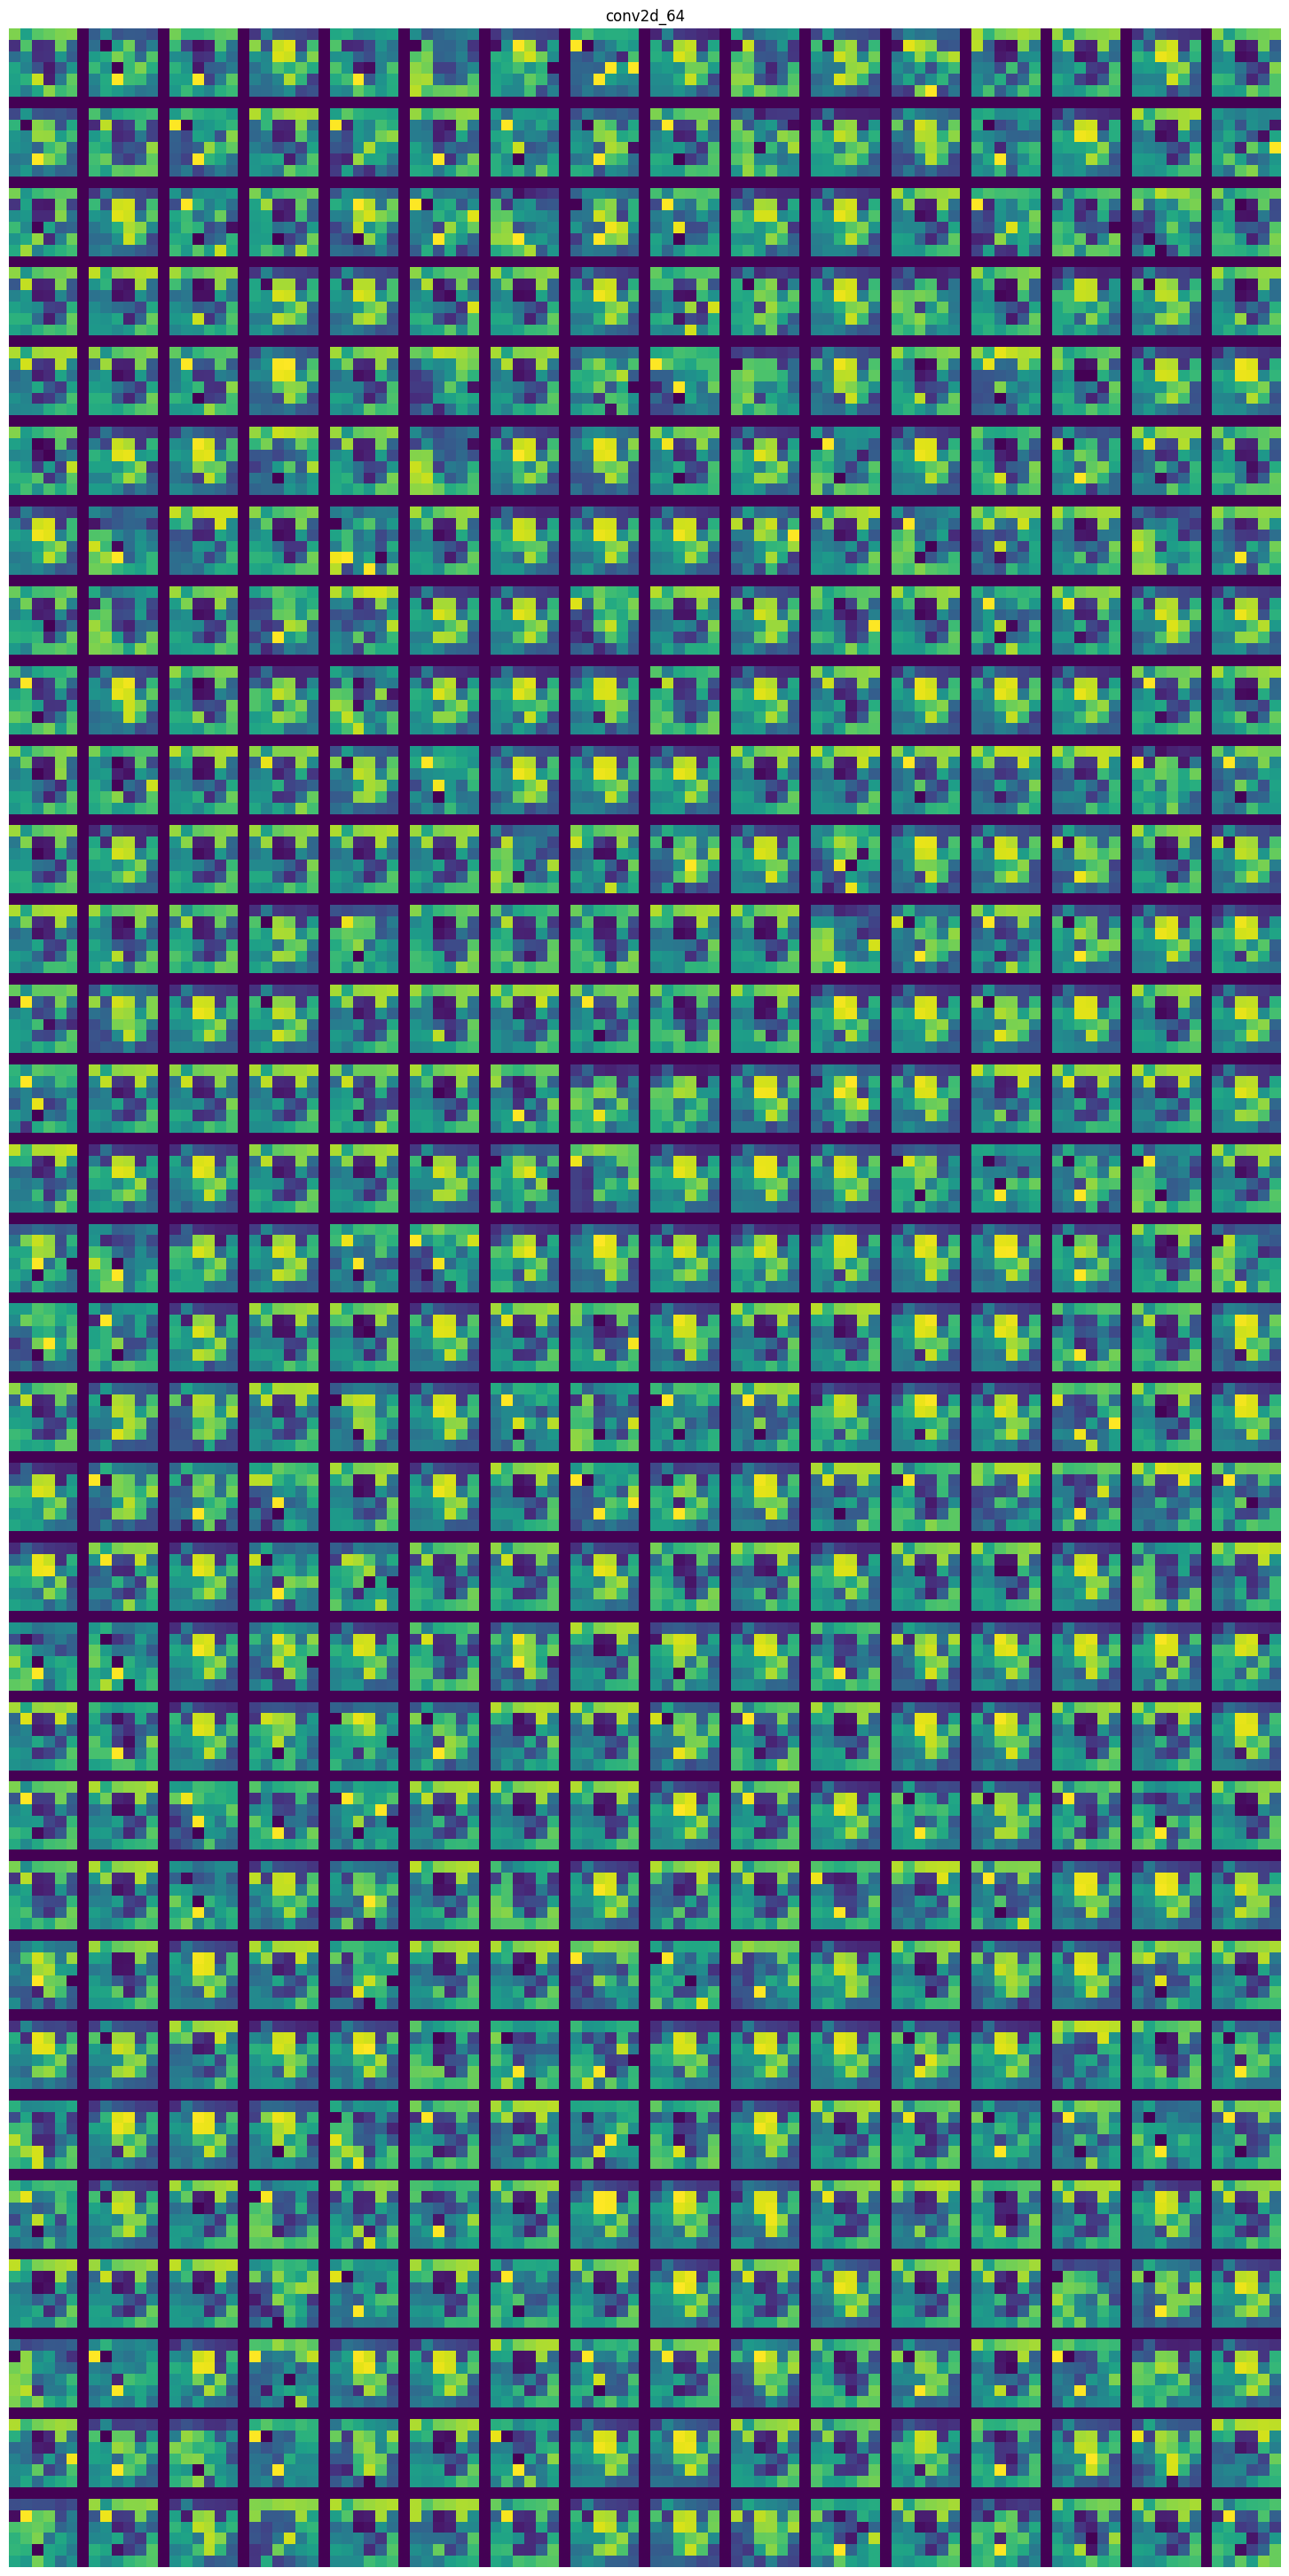

In [ ]:
scale = 1. / size
plt.figure(figsize=(scale* display_grid.shape[1],scale* display_grid.shape[0]))
plt.title(layer_name)
plt.grid(False)
plt.axis("off" )
plt.imshow(display_grid, aspect="auto", cmap="viridis")

In [ ]:
model = keras.applications.xception.Xception(weights="imagenet",include_top=False)
#Printing the names of all convolutional layers in Xception
for layer in model.layers:
  if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
    print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d_69
block3_sepconv1
block3_sepconv2
conv2d_70
block4_sepconv1
block4_sepconv2
conv2d_71
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_72
block14_sepconv1
block14_sepconv2


In [ ]:
#Creating a feature extractor model
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor =keras.Model(inputs=model.input,outputs=layer.output)

In [ ]:
#Using the feature extractor
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

def compute_loss(image, filter_index):
 activation = feature_extractor(image)
 filter_activation = activation[:, 2:-2, 2:-2, filter_index]
 return tf.reduce_mean(filter_activation)

In [ ]:
import tensorflow as tf

#Loss maximization via stochastic gradient ascent
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(image)
    loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

In [ ]:
# Function to generate filter visualizations
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
  iterations = 30
  learning_rate = 10.
  image = tf.random.uniform(minval=0.4,
                            maxval=0.6,
                            shape=(1, img_width, img_height,3))
  for i in range(iterations):
    image = gradient_ascent_step(image, filter_index, learning_rate)
  return image[0].numpy()

In [ ]:
#Utility function to convert a tensor into a valid image
def deprocess_image(image):
  image -= image.mean()
  image /= image.std()
  image *= 64
  image += 128
  image = np.clip(image, 0, 255).astype("uint8")
  image = image[25:-25, 25:-25, :]
  return image

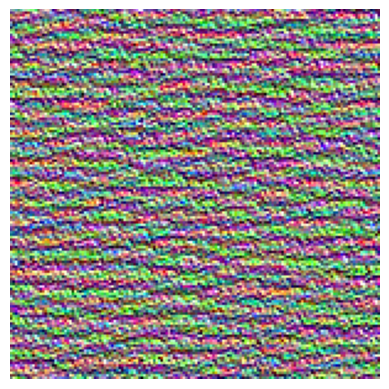

In [ ]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

In [ ]:
#Generating a grid of all filter response patterns in a layer
all_images = []
for filter_index in range(64):
  print(f"Processing filter {filter_index}")
  image = deprocess_image(generate_filter_pattern(filter_index))
  all_images.append(image)


margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height,3))

for i in range(n):
  for j in range(n):
    image = all_images[i* n + j]
    row_start = (cropped_width + margin) * i
    row_end = (cropped_width + margin) * i + cropped_width
    column_start = (cropped_height + margin) * j
    column_end = (cropped_height + margin) * j + cropped_height

    stitched_filters[
        row_start: row_end,
        column_start: column_end, :] = image

keras.utils.save_img(f"filters_for_layer_{layer_name}.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr